In [13]:
%pylab inline
import numpy as np
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [14]:
path='/home/jfm343/Documents/Moire_phonon/BM_bandstructure/Mods/data20_mode_L_symmetry_a_alpha_0.0_beta_1.0_umklp_0_kappa_0.8174358974358973_theta_0.01832595714594046.h5'
df = pd.read_hdf(path)

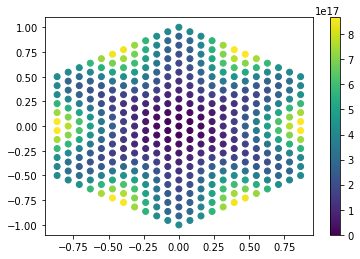

In [15]:
df_prime=df.loc[df['nu']==0]
scatter(df_prime['kx'],df_prime['ky'], c=df_prime['bub'])
colorbar()

Text(0, 0.5, '$\\alpha/ c_L$')

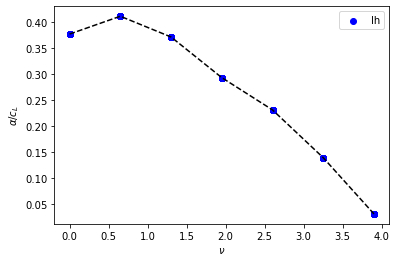

In [21]:

fillings=df['nu']
cep=df['delt_cph']/21400
plt.scatter(fillings, cep, c='b', label='lh')
plt.plot(fillings, cep, c='k', ls='--')
plt.legend()
plt.xlabel(r"$\nu$")
plt.ylabel(r"$\alpha/ c_L$")
# plt.savefig("velocities_V_filling_"+self.name+"_"+str(Nsamp)+"_theta_"+str(theta)+".png")


## For the sound velocity

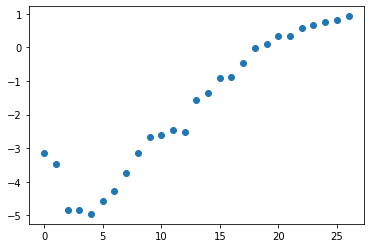